In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
import datetime
import math

In [2]:
from pypfopt import expected_returns
from pypfopt import risk_models
from pypfopt import efficient_frontier
from pypfopt import objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

In [3]:
import pandas as pd
from pandas_datareader import data as pdr
import datetime
import yfinance as yfin
yfin.pdr_override()

def _load_prices(
    ticker: str,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> pd.DataFrame:
    return pdr.get_data_yahoo(ticker, start='2000-01-01', end=end).loc[:, 'Adj Close']

def load_prices_multitickers(
    tickers: list,
    data_source: str = 'yahoo',
    end: str = datetime.date.today()
) -> list:
    prices = pd.DataFrame()
    for t in tickers:
        prices[t] = _load_prices(t, data_source, end)
        
    return prices.fillna(value=None, method="ffill", axis=0, inplace=False).dropna(axis=0, how='any', inplace=False)

In [4]:
def calc_omega(views):
    variances = []
    for symbol, view in views.items():
        lb, ub  = view[0], view[2]
        std_dev = (ub - lb)/2
        variances.append(std_dev ** 2)
    omega = np.diag(variances)
    return omega

def load_mean_views(views):
    mu = {}
    for symbol, view in views.items():
        mu[symbol] = view[1]
    return mu

In [5]:
def load_gdp_data(fname: str) -> pd.DataFrame:
    world_gdp = pd.read_csv(
        fname, 
        sep=",", 
        header=2,
        index_col="Country Code", 
        #names=["Date", "mkt"], 
        skipinitialspace=True,
        skip_blank_lines=True,
        parse_dates=True,
        infer_datetime_format=True
    ).loc["WLD"].iloc[3:].dropna().astype('float64').reset_index()
    
    world_gdp.loc[:, 'index'] = pd.to_datetime(world_gdp.loc[:, 'index'])
    return world_gdp.set_index('index')

def interpolate_gdp_data(df_gdp : pd.DataFrame) -> pd.DataFrame:
    temp = pd.DataFrame(
        pd.date_range(start=g.index[0], end=g.index[-1], freq='D'),
        columns=["date"]
    )
    temp.loc[:, 'dmy'] = math.nan
    i_gdp = temp.set_index('date').join(df_gdp).drop('dmy', axis=1).interpolate(method = 'akima', axis=0)
    
    return i_gdp

In [6]:
tickers = ['VOO', 'BND', 'VXUS', 'BNDX']
prices=load_prices_multitickers(tickers, 'yahoo')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
msci = pd.read_csv("./data/msci.csv", sep=",", header=0, index_col="Date", names=["Date", "mkt"], skipinitialspace=True, skip_blank_lines=True, parse_dates=True, infer_datetime_format=True, thousands=",")
msci

,mkt
Date,
1994-05-31,392.682
1994-06-30,392.593
1994-07-29,398.298
1994-08-31,410.747
1994-09-30,400.733
...,...
2023-08-31,1732.630
2023-09-29,1657.168
2023-10-31,1600.928


In [8]:
g = load_gdp_data("./data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4251000.csv")
g = pd.DataFrame(interpolate_gdp_data(g).join(prices).dropna(axis=0, how='any', inplace=False).loc[:, "WLD"].rename("mkt"))
g

,mkt
date,
2013-06-04,7.849682e+13
2013-06-05,7.850259e+13
2013-06-06,7.850835e+13
2013-06-07,7.851412e+13
2013-06-10,7.853141e+13
...,...
2020-12-24,9.570453e+13
2020-12-28,9.590192e+13
2020-12-29,9.595139e+13


In [9]:
rets = {}
covs = {}

In [10]:
risk_free_rate=1.005**((1/252)) - 1
risk_free_rate

1.9792027252663047e-05

In [11]:
rets['mhr'] = expected_returns.mean_historical_return(prices, frequency=252)
rets['ehr'] = expected_returns.ema_historical_return(prices, frequency=252, span=252*5)
rets['capmr'] = expected_returns.capm_return(prices,  risk_free_rate=risk_free_rate, compounding=True, frequency=252)

In [12]:
covs['sample_cov'] = risk_models.risk_matrix(prices, method='sample_cov')
covs['semicovariance'] = risk_models.risk_matrix(prices, method='semicovariance', benchmark=risk_free_rate, frequency=252, log_returns=False)
covs['exp_cov'] = risk_models.risk_matrix(prices, method='exp_cov', span=252*5, frequency=252)

In [13]:
covs['ledoiid_wolf_cc'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_correlation', frequency=252)
covs['ledoiid_wolf_sf'] = risk_models.risk_matrix(prices, method='ledoit_wolf_single_factor', frequency=252)
covs['ledoiid_wolf_cv'] = risk_models.risk_matrix(prices, method='ledoit_wolf_constant_variance', frequency=252)
covs['oracle_approx'] = risk_models.risk_matrix(prices, method='oracle_approximating', frequency=252)

In [14]:
rets

{'mhr': VOO     0.138762
 BND     0.016021
 VXUS    0.049935
 BNDX    0.023203
 dtype: float64,
 'ehr': VOO     0.189257
 BND     0.007851
 VXUS    0.068014
 BNDX    0.019746
 Name: 2024-12-27 00:00:00, dtype: float64,
 'capmr': VOO     0.110315
 BND     0.012544
 VXUS    0.108680
 BNDX    0.008677
 Name: mkt, dtype: float64}

In [15]:
covs

{'sample_cov':            VOO       BND      VXUS      BNDX
 VOO   0.029066  0.000870  0.024397  0.000650
 BND   0.000870  0.002707  0.001177  0.001489
 VXUS  0.024397  0.001177  0.027948  0.000645
 BNDX  0.000650  0.001489  0.000645  0.001531,
 'semicovariance':            VOO       BND      VXUS      BNDX
 VOO   0.014832  0.001715  0.013131  0.001283
 BND   0.001715  0.001420  0.001898  0.000838
 VXUS  0.013131  0.001898  0.015105  0.001348
 BNDX  0.001283  0.000838  0.001348  0.000776,
 'exp_cov':            VOO       BND      VXUS      BNDX
 VOO   0.029021  0.001979  0.022700  0.001348
 BND   0.001979  0.003904  0.002474  0.002400
 VXUS  0.022700  0.002474  0.026140  0.001454
 BNDX  0.001348  0.002400  0.001454  0.002224,
 'ledoiid_wolf_cc':            VOO       BND      VXUS      BNDX
 VOO   0.029066  0.000901  0.024177  0.000674
 BND   0.000901  0.002707  0.001203  0.001477
 VXUS  0.024177  0.001203  0.027948  0.000668
 BNDX  0.000674  0.001477  0.000668  0.001531,
 'ledoiid_wolf

In [16]:
mcaps = {
    'VOO': 52370474000000.01,
    'BND': 49000000000000,
    'VXUS': 41315525999999.99,
    'BNDX': 70000000000000
}
mcaps

{'VOO': 52370474000000.01,
 'BND': 49000000000000,
 'VXUS': 41315525999999.99,
 'BNDX': 70000000000000}

In [17]:
delta = black_litterman.market_implied_risk_aversion(g.iloc[:-365, 0], frequency=252, risk_free_rate=0.005)
delta

844.8011584382269

In [18]:
delta1 = black_litterman.market_implied_risk_aversion(prices["VOO"][:-252*3], frequency=252, risk_free_rate=0.005)
delta2 = black_litterman.market_implied_risk_aversion(prices["BND"][:-252*3], frequency=252, risk_free_rate=0.005)
delta3 = black_litterman.market_implied_risk_aversion(prices["VXUS"][:-252*3], frequency=252, risk_free_rate=0.005)
delta4 = black_litterman.market_implied_risk_aversion(prices["BNDX"][:-252*3], frequency=252, risk_free_rate=0.005)
print(delta1, delta2, delta3, delta4)
delta=delta1

5.317389796857377 13.464805946722906 2.495642667000474 30.238951388404484


In [19]:
delta = black_litterman.market_implied_risk_aversion(msci.iloc[:, 0], frequency=12, risk_free_rate=0.005)
delta

2.450249865843789

In [36]:
viewdict = {
    "VOO":[0.05, 0.1, 0.15],
    "BND":[0.0, 0.015, 0.02],
    "VXUS":[0.03, 0.07, 0.1],
    "BNDX":[0.0, 0.015, 0.02]
}
omega = calc_omega(viewdict)
mu = load_mean_views(viewdict)

In [37]:
cov_matrix = covs['oracle_approx']
bl = BlackLittermanModel(cov_matrix, pi="market", market_caps=mcaps, risk_aversion=delta, absolute_views=mu, omega=omega)
rets['bl_post'] = bl.bl_returns()
covs['bl_post'] = bl.bl_cov()
rets

{'mhr': VOO     0.138762
 BND     0.016021
 VXUS    0.049935
 BNDX    0.023203
 dtype: float64,
 'ehr': VOO     0.189257
 BND     0.007851
 VXUS    0.068014
 BNDX    0.019746
 Name: 2024-12-27 00:00:00, dtype: float64,
 'capmr': VOO     0.110315
 BND     0.012544
 VXUS    0.108680
 BNDX    0.008677
 Name: mkt, dtype: float64,
 'bl_post': VOO     0.063424
 BND     0.012422
 VXUS    0.060768
 BNDX    0.009598
 dtype: float64}

In [38]:
r = 0.04
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
#w = ef_bl.max_sharpe(risk_free_rate=0.005)
w = ef_bl.efficient_return(r)
perf_bst = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_bst)

Expected annual return: 4.0%
Annual volatility: 9.7%
Sharpe Ratio: 0.36
OrderedDict([('VOO', 0.28560484250276), ('BND', 0.218388706691424), ('VXUS', 0.2816554125343994), ('BNDX', 0.2143510382714166)])
(0.04000000000000001, 0.09709030435425005, 0.36048913671438)


In [39]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix, weight_bounds=(0.05, 0.6))
ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_mshL2 = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_mshL2)

Expected annual return: 5.7%
Annual volatility: 14.7%
Sharpe Ratio: 0.35
OrderedDict([('VOO', 0.4559886723071607), ('BND', 0.059279457711769), ('VXUS', 0.4347318699810701), ('BNDX', 0.05)])
(0.05655466464393193, 0.1468623025992592, 0.35104083029808075)


/root/.pyenv/versions/3.10.1/lib/python3.10/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:257: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


In [40]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
w = ef_bl.max_sharpe(risk_free_rate=0.005)
perf_msh = ef_bl.portfolio_performance(verbose=True, risk_free_rate=0.005)

print(w)
print(perf_msh)

Expected annual return: 3.6%
Annual volatility: 8.7%
Sharpe Ratio: 0.36
OrderedDict([('VOO', 0.2976489370398625), ('BND', 0.4079133522152122), ('VXUS', 0.1895002512582719), ('BNDX', 0.1049374594866532)])
(0.036467837488478205, 0.08670515448283242, 0.362929259236933)


In [41]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

min_ret = max(0, min(expected_return))
max_ret = min(0.25, max(expected_return))
rets_seq = list(np.arange(min_ret, max_ret, 0.001))

weights = {}
max_sr = -1
max_r = 0.0
for r in rets_seq:
    _ef_bl = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)
    _ef_bl.add_objective(objective_functions.L2_reg, gamma=1.0)
    _w = _ef_bl.efficient_return(r)
    _perf = _ef_bl.portfolio_performance(verbose=False, risk_free_rate=0.005)
    
    weights[r] = (_perf, _w)
    
    if _perf[2] >= max_sr:
        max_sr = _perf[2]
        max_r = r
print("{0}:{1}".format(max_r, max_sr))
print(weights[max_r])

0.035598357846543326:0.36172046876556385
((0.03592807013133078, 0.08550268177213852, 0.36172046876556385), OrderedDict([('VOO', 0.2437845106891324), ('BND', 0.2558625898313382), ('VXUS', 0.244001723355271), ('BNDX', 0.2563511761242582)]))


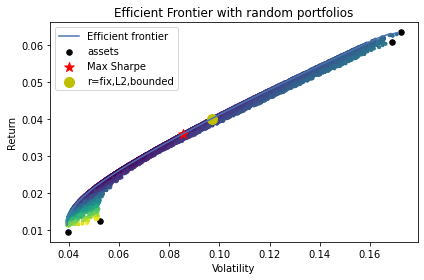

In [42]:
expected_return = rets['bl_post']
cov_matrix = covs['bl_post']

ef_for_plot = efficient_frontier.EfficientFrontier(expected_return, cov_matrix)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef_for_plot, ax=ax, show_assets=True)

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(expected_return)), n_samples)
r = w.dot(expected_return)
s = np.sqrt(np.diag(w @ cov_matrix @ w.T))
sharpes = r / s
ax.scatter(s, r, marker=".", c=sharpes, cmap="viridis_r")

ret_tangent, std_tangent, _ = weights[max_r][0]
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

ret_bst, std_bst, _ = perf_bst
ax.scatter(std_bst, ret_bst, marker="o", s=100, c="y", label="r=fix,L2,bounded")

ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

In [34]:
from sklearn.model_selection import TimeSeriesSplit

In [35]:
tscv = TimeSeriesSplit(n_splits=3, max_train_size=252*5, test_size=252, gap=0)
for train, test in tscv.split(prices):
    print(prices.iloc[train, :])
    print("\n")

                   VOO        BND       VXUS       BNDX
Date                                                   
2016-12-22  180.638000  64.045486  35.671207  42.794945
2016-12-23  180.795044  64.077438  35.773262  42.882046
2016-12-27  181.240067  64.029541  35.781116  42.874123
2016-12-28  179.809021  64.189232  35.757565  42.937473
2016-12-29  179.774109  64.364815  35.953823  43.016617
...                ...        ...        ...        ...
2021-12-17  403.975281  77.582130  56.189278  50.461639
2021-12-20  399.605988  77.454918  55.809109  50.417679
2021-12-21  406.697815  77.373131  56.553112  50.162727
2021-12-22  410.805908  77.454918  57.061207  50.197910
2021-12-23  413.337769  77.337318  57.378769  50.087524

[1260 rows x 4 columns]


                   VOO        BND       VXUS       BNDX
Date                                                   
2017-12-22  218.639587  66.742180  45.630386  43.949669
2017-12-26  218.385284  66.808792  45.654617  43.958580
2017-12-27  218.50978